# Binkowski: toy example
This is an toy example that demonstrates Binkowski's method.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

import itertools

import matplotlib.pyplot as plt

### Functions for generation and visualization of the image batches

In [2]:
def visualize_img_batch(batch):
    '''Visualizes image batch
    
    Parameters:
    batch (Tensor): An image batch
    '''
    grid = make_grid(batch, nrow=8, padding=1, normalize=False, range=None, scale_each=False, pad_value=0)
    plt.imshow(grid.permute(1,2,0))
    plt.show()

In [3]:
def random_image_data(size=(2**21, 3, 1, 1), ratio=0.5, offset=0.2, color=0, std=0):
    '''Generates a random image batch 
    consisting of two modes (dark and light images)
    
    Parameters:
    size (tuple): The dimensions of the image batch (batch_size, channels, width, length)
    ratio (float): The ratio of light to dark images
    offset (float): The brightness of the images relative to black and bright
    color (int): Red = 0, green = 1, blue = 2
    
    Returns:
    image_batch (Tensor): The generated image batch
    
    '''
    idx = torch.randperm(size[0])[:int(ratio*size[0])] # Randomly choose indices according to the ratio
    
    m = torch.distributions.normal.Normal(torch.Tensor([0]), torch.ones((int(torch.prod(torch.Tensor(size)))))*std)
    
    image_batch = torch.zeros(size)
    image_batch[:, color] += offset # light color
    image_batch[idx, color] = 1 - offset # dark color 
    
    image_batch += m.sample().view(size)
    return image_batch.clamp(0, 1)

### The dataset class

In [4]:
class ColorDataset(Dataset):
    '''The dataloader for the color images
    '''
    def __init__(self, ratio=0.5, offset=0.2, color=0, std=0):
        '''  
        Parameters:
        ratio (float): The ratio of light to dark images
        offset (float): The brightness of the images relative to black and bright
        color (int): Red = 0, green = 1, blue = 2
        std (float): the standard deviation of the noise in the data set
        '''
        self.offset = offset
        self.ratio = ratio
        self.color = color
        self.std = std
        
        self.dataset = random_image_data(ratio=self.ratio, 
                                         offset=self.offset, 
                                         color=self.color,
                                         std=self.std)
        self.example_imgs = self.example()
        
    def example(self):
        '''
        Returns an example from each mode in the domain
        
        '''
        example_imgs = torch.zeros(size=(2, 3, 1, 1))

        example_imgs[0, self.color] += self.offset # light color
        example_imgs[1, self.color] = 1 - self.offset # dark color
        return example_imgs

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):      
        return self.dataset[idx]

### The networks

In [5]:
class WeightNet(nn.Module):
    '''A simple network that predicts the importances of the samples'''

    def __init__(self):
        super(WeightNet, self).__init__()
        self.fc1 = nn.Linear(3, 1)
        self.fc2 = nn.Linear(1, 1)
        
    def forward(self, x):
        h1 = torch.sigmoid(self.fc1(x.view(-1, 3)))
        out = self.fc2(h1)
        return out

In [6]:
class TrivialWeightNet(nn.Module):
    '''A trivial network that predicts the importances of the samples'''

    def __init__(self):
        super(TrivialWeightNet, self).__init__()
        self.fc1 = nn.Linear(1, 1)
        
    def forward(self, x):
        return torch.ones((x.shape[0], 1))

In [7]:
class Discriminator(nn.Module):
    '''A simple joint discriminator network'''

    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(6, 6)
        self.fc2 = nn.Linear(6, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        h1 = self.dropout(torch.relu(self.fc1(x.view(-1, 6))))
        out = self.fc2(h1)
        return out

In [8]:
class TrivialDiscriminator(nn.Module):
    '''A trivial joint discriminator network'''

    def __init__(self):
        super(TrivialDiscriminator, self).__init__()
        self.fc1 = nn.Linear(1, 1)
        
    def forward(self, x):
        return torch.zeros(x.size()[0], 1)

In [9]:
class Generator(nn.Module):
    '''A simple conditional generator network'''

    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(3, 3)
        self.fc2 = nn.Linear(3, 3)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        h1 = self.dropout(F.relu(self.fc1(x.view(-1, x.shape[1]))))
        out = torch.sigmoid(self.fc2(h1))
        return out.unsqueeze(-1).unsqueeze(-1)#.clamp(0, 1)

In [10]:
class TrivialGenerator(nn.Module):
    '''A trivial conditional generator network'''
    
    def __init__(self):
        super(TrivialGenerator, self).__init__()
        self.nn = nn.Linear(3,1) # Otherwise error
        
    def forward(self, x):
        new = torch.zeros((x.shape))
        new[:, 0] = x[:, 1]
        new[:, 1] = x[:, 0]
        out = self.nn(x.squeeze().squeeze())
        return new + out.unsqueeze(1).unsqueeze(1)

### A demonstration of the two domains
The idea here is that we create two domains: A red and a green domain. The domains consist of two modes: dark and light images. The big assumption here for our purpose is that the dark and light images have semantic correspondance, so for example: dark red will be translated to dark green.

We can adjust the intensity of the images (offset) and the ratio of the modes for the experiment. In the visualiztion you can see the elements of the dataset. In the histogram you can see the modes.

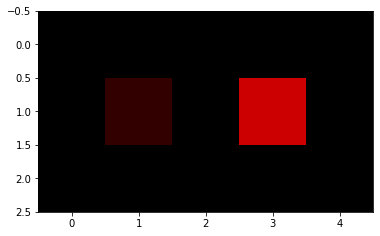

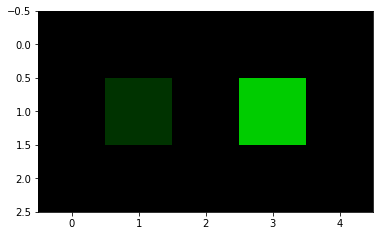

In [11]:
# Settings for domain A (red)
offset_A = 0.2
ratio_A = 0.5
color_A = 0
std_A = 0.05
dataset_A = ColorDataset(offset=offset_A, ratio=ratio_A, color=color_A, std=std_A)
dataloader_A = DataLoader(dataset_A, batch_size=128, shuffle=True)

# Settings for domain B (green)
offset_B = 0.2
ratio_B = 0.5
color_B = 1
std_B = 0.05
dataset_B = ColorDataset(offset=offset_B, ratio=ratio_B, color=color_B, std=std_B)
dataloader_B = DataLoader(dataset_B, batch_size=128, shuffle=True)

visualize_img_batch(dataset_A.example_imgs)
visualize_img_batch(dataset_B.example_imgs)

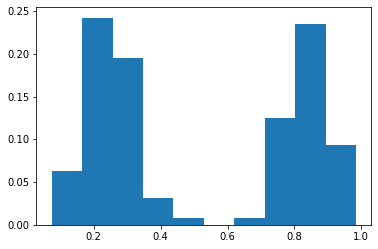

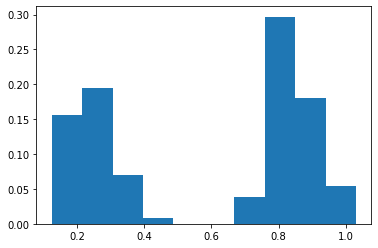

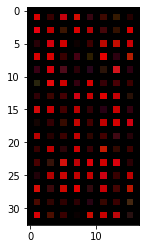

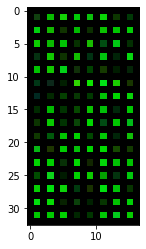

In [12]:
def plot_hist(data):
    data = data.view(3, -1).sum(0)
    plt.hist(data, weights=torch.ones(len(data))/len(data))
    x_unique_count = torch.stack([(data==x_u).sum() for x_u in data.unique()])
    
#     print('Count:', x_unique_count, 'Ratio in this batch:', x_unique_count/float(x_unique_count.sum()))

    plt.show()

for i, (data_A, data_B) in enumerate(zip(dataloader_A, dataloader_B)):
#     print('True ratio domain A:', dataloader_A.dataset.ratio)
    plot_hist(data_A)
#     print('True ratio domain B:', dataloader_B.dataset.ratio)
    plot_hist(data_B)
    
    visualize_img_batch(data_A)
    visualize_img_batch(data_B)
    break

## The training loop

In [13]:
# Initialize the networks
weight_network_A = TrivialWeightNet()
weight_network_B = TrivialWeightNet()
generator_A = Generator()
generator_B = Generator()
discriminator = Discriminator()

# Initialize the optimizers
optimizer_w = optim.Adam(itertools.chain(weight_network_A.parameters(), 
                                         weight_network_B.parameters()), lr=0.001)
optimizer_g = optim.Adam(itertools.chain(generator_A.parameters(),
                                         generator_B.parameters()), lr=0.001)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.001)

# Store values
samples_A = []
samples_B = []

losses_g = []
losses_d = []
losses_w = []

Lminusses = []
Lplusses = []

example_importances_A = []
example_importances_B = []

example_d_real = []
example_d_sample = []

penalties = []

for epoch in range(1):
    for i, (real_A, real_B) in enumerate(zip(dataloader_A, dataloader_B)):

        # Generated images
        fake_A = generator_A(real_B)
        fake_B = generator_B(real_A)

        # The weighting process
        w = 0.5*(torch.sigmoid(weight_network_A(real_A)) + torch.sigmoid(-weight_network_B(fake_B.detach())))
        v = 0.5*(torch.sigmoid(-weight_network_A(fake_A.detach())) + torch.sigmoid(weight_network_B(real_B)))
                 
        # The loss function --------------------------------------------------------------------------------
        
        # For storing purposes
        Lmin = (discriminator(torch.cat((real_A, fake_B))) * 0.5*(1 + w.detach())).sum().detach()
        Lplus = (discriminator(torch.cat((fake_A, real_B))) * 0.5*(1 + v.detach())).sum().detach()
        
        activation_penalty_A = (discriminator(torch.cat((fake_A.detach(), real_B)))**2).sum()
        activation_penalty_B = (discriminator(torch.cat((real_A, real_B.detach())))**2).sum()
        lambda_penalty = 0.001
        
        # The losses that are used for backprop
        # Wants to predict D(fake_A, real_B) = -1, D(real_A, fake_B) = 1
        loss_d = (discriminator(torch.cat((fake_A.detach(), real_B))) * 0.5*(1 + v.detach())).sum() - \
                 (discriminator(torch.cat((real_A, fake_B.detach()))) * 0.5*(1 + w.detach())).sum() + \
                 lambda_penalty*(activation_penalty_A + activation_penalty_B)


        loss_w = ((discriminator(torch.cat((real_A, fake_B.detach()))).detach() * 0.5*(1 + w)).sum() - \
                  (discriminator(torch.cat((fake_A.detach(), real_B))).detach() * 0.5*(1 + v)).sum())**2
        
        # Wants to predict D(fake_A, real_B) = 1, D(real_A, fake_B) = -1
        loss_g = (discriminator(torch.cat((real_A, fake_B))) * 0.5*(1 + w.detach())).sum() - \
                 (discriminator(torch.cat((fake_A, real_B))) * 0.5*(1 + v.detach())).sum()
        # ---------------------------------------------------------------------------------------------------

        # Backward
        
#         optimizer_d.zero_grad()
#         loss_d.backward()
#         optimizer_d.step()
        
#         optimizer_w.zero_grad()
#         loss_w.backward()
#         optimizer_w.step()       
        
        if i % 5 == 0:
            optimizer_g.zero_grad()
            loss_g.backward()
            optimizer_g.step()
        else:
            optimizer_d.zero_grad()
            loss_d.backward()
            optimizer_d.step()

        # Store values --------------------------------------------------------------------------------------
        Lminusses += [Lmin.item()]
        Lplusses += [Lplus.item()]

        losses_g += [loss_g.item()]
        losses_d += [loss_d.item()]
        losses_w += [loss_w.item()]
        
        penalties += [(activation_penalty_A.item(), activation_penalty_B.item())]

        w_a = weight_network_A(dataset_A.example_imgs)
        w_b = weight_network_B(dataset_B.example_imgs)
        example_importances_A += [(w_a[0].item(), w_a[1].item())] # Store examples in a list
        example_importances_B += [(w_b[0].item(), w_b[1].item())] # Store examples in a list
        
        d_r1 = discriminator(torch.cat((dataset_A.example_imgs[0], dataset_B.example_imgs[0])))
        d_r2 = discriminator(torch.cat((dataset_A.example_imgs[1], dataset_B.example_imgs[1])))              
        example_d_real += [(d_r1.item(), d_r2.item())] # Store examples in a list

        d_a = discriminator(torch.cat((real_A[0], fake_B[0])))
        d_b = discriminator(torch.cat((fake_A[0], real_B[0])))     
        example_d_sample += [(d_a.item(), d_b.item())] # Store examples in a list
        
        # ---------------------------------------------------------------------------------------------------

        # Print statistics
        if i % 500 == 0:
            samples_A += [fake_A.detach()]
            samples_B += [fake_B.detach()]
            print('step', i, 'loss_g: ', loss_g.item(), 'loss_d: ', loss_d.item(), 'loss_w: ', loss_w.item())

step 0 loss_g:  -5.8141326904296875 loss_d:  10.589570045471191 loss_w:  48.830528259277344
step 500 loss_g:  157.85684204101562 loss_d:  -140.4720916748047 loss_w:  19621.884765625
step 1000 loss_g:  170.0386505126953 loss_d:  -165.79690551757812 loss_w:  31368.67578125
step 1500 loss_g:  302.72528076171875 loss_d:  -278.6185607910156 loss_w:  64443.55859375
step 2000 loss_g:  285.09332275390625 loss_d:  -315.6847229003906 loss_w:  60606.36328125
step 2500 loss_g:  269.2779541015625 loss_d:  -250.35824584960938 loss_w:  89546.765625
step 3000 loss_g:  303.36981201171875 loss_d:  -280.70599365234375 loss_w:  83949.453125
step 3500 loss_g:  227.94395446777344 loss_d:  -273.2704162597656 loss_w:  58522.05078125
step 4000 loss_g:  331.0169372558594 loss_d:  -253.40379333496094 loss_w:  131972.9375
step 4500 loss_g:  425.87164306640625 loss_d:  -541.3121337890625 loss_w:  99332.8515625
step 5000 loss_g:  55.10797119140625 loss_d:  -36.118141174316406 loss_w:  38228.24609375
step 5500 loss_

In [14]:
weight_network_A = weight_network_A.eval()
weight_network_B = weight_network_B.eval()
generator_A = generator_A.eval()
generator_B = generator_B.eval()
discriminator = discriminator.eval()

for i, (real_A, real_B) in enumerate(zip(dataloader_A, dataloader_B)):
    # Generated images
    fake_A = generator_A(real_B)
    fake_B = generator_B(real_A)
    break

### Interpretation

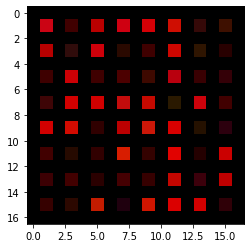

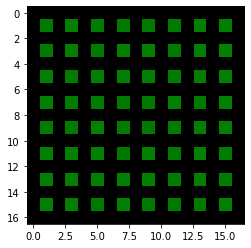

True ratio domain A 0.5


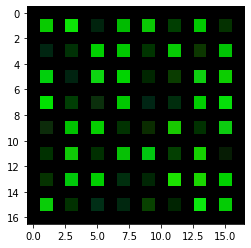

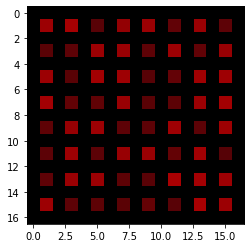

True ratio domain B 0.5


In [15]:
visualize_img_batch(real_A[:64])
visualize_img_batch(fake_B.detach()[:64])
print('True ratio domain A {}'.format(ratio_A))
# plot_hist(real_A)

visualize_img_batch(real_B[:64])
visualize_img_batch(fake_A.detach()[:64])
print('True ratio domain B {}'.format(ratio_B))
# plot_hist(real_B)

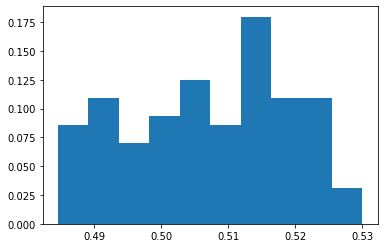

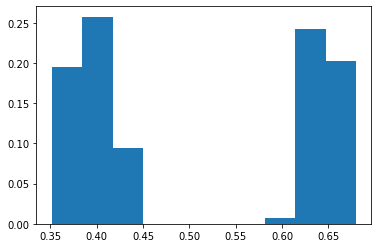

In [16]:
plot_hist(fake_B.detach())
plot_hist(fake_A.detach())

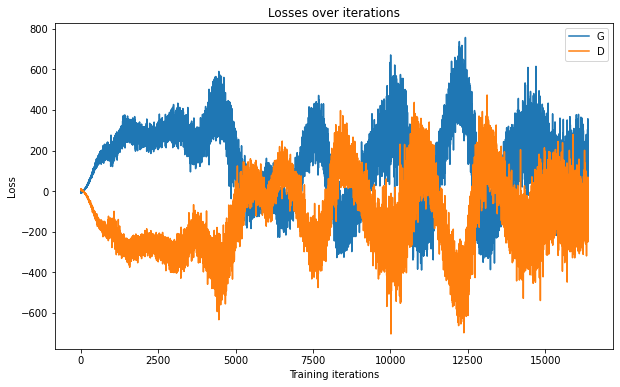

In [17]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
# plt.yscale('symlog')
plt.plot(losses_g)
plt.plot(losses_d)
plt.legend(['G', 'D'])
plt.show()

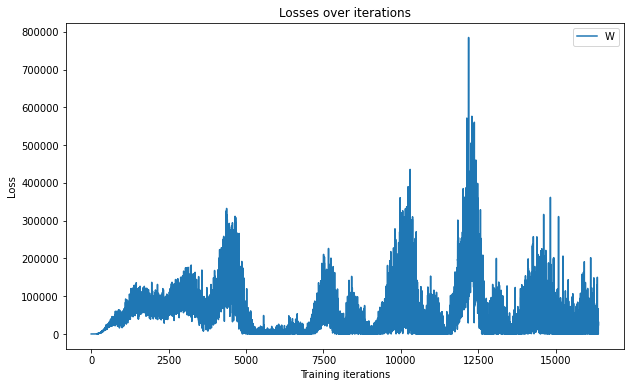

In [18]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
# plt.yscale('symlog')
plt.plot(losses_w)
plt.legend(['W'])
plt.show()

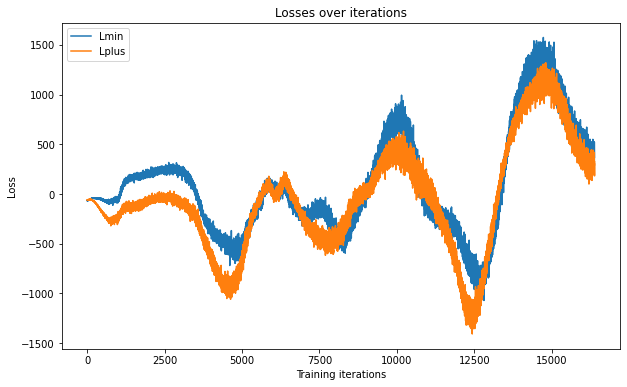

In [19]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.plot(Lminusses)
plt.plot(Lplusses)
plt.legend(['Lmin', 'Lplus'])
plt.show()

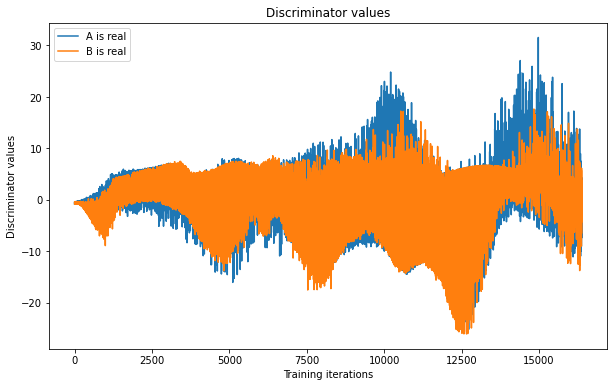

In [20]:
plt.figure(figsize=(10,6))
plt.title('Discriminator values')
plt.plot(torch.Tensor(example_d_sample)[:, 0])
plt.plot(torch.Tensor(example_d_sample)[:, 1])
plt.legend(['A is real', 'B is real'])
plt.ylabel('Discriminator values')
plt.xlabel('Training iterations')
plt.show()

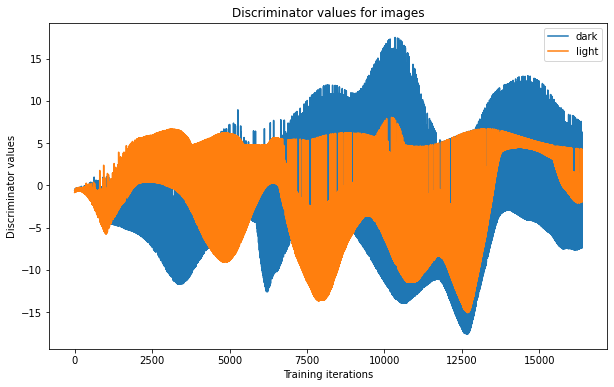

In [21]:
plt.figure(figsize=(10,6))
plt.title('Discriminator values for images')
plt.plot(torch.Tensor(example_d_real)[:, 0])
plt.plot(torch.Tensor(example_d_real)[:, 1])
plt.legend(['dark', 'light'])
plt.ylabel('Discriminator values')
plt.xlabel('Training iterations')
plt.show()

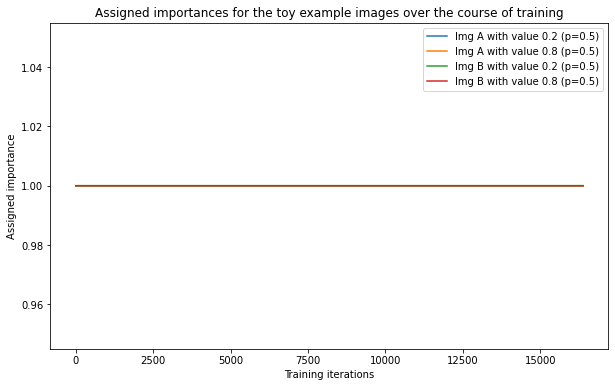

In [22]:
plt.figure(figsize=(10,6))
plt.title('Assigned importances for the toy example images over the course of training')
plt.plot(example_importances_A)
plt.plot(example_importances_B)
plt.legend(['Img A with value {} (p={})'.format(offset_A, ratio_A), 
            'Img A with value {} (p={})'.format(1-offset_A, 1-ratio_A), 
            'Img B with value {} (p={})'.format(offset_B, ratio_B), 
            'Img B with value {} (p={})'.format(1-offset_B, 1-ratio_B)])
plt.ylabel('Assigned importance')
plt.xlabel('Training iterations')
plt.show()

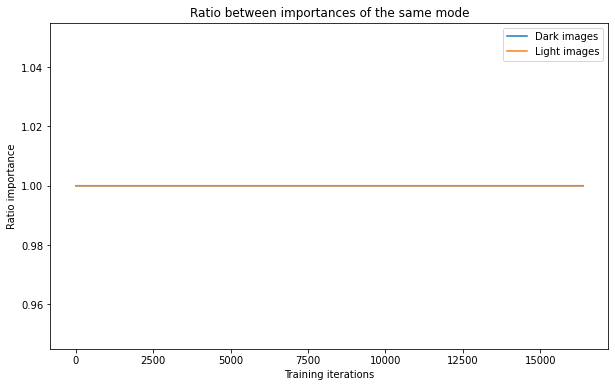

In [23]:
plt.figure(figsize=(10,6))
plt.title('Ratio between importances of the same mode')
plt.plot(torch.Tensor(example_importances_A)[:, 0]/torch.Tensor(example_importances_B)[:, 0])
plt.plot(torch.Tensor(example_importances_A)[:, 1]/torch.Tensor(example_importances_B)[:, 1])
plt.legend(['Dark images', 'Light images'])
plt.ylabel('Ratio importance')
plt.xlabel('Training iterations')
plt.show()

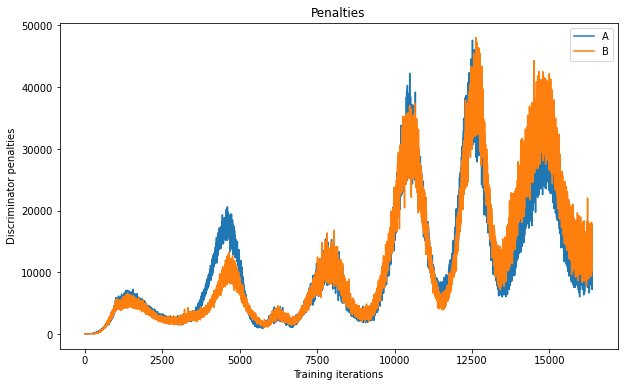

In [24]:
plt.figure(figsize=(10,6))
plt.title('Penalties')
plt.plot(torch.Tensor(penalties)[:, 0])
plt.plot(torch.Tensor(penalties)[:, 1])
plt.legend(['A', 'B'])
plt.ylabel('Discriminator penalties')
plt.xlabel('Training iterations')
plt.show()

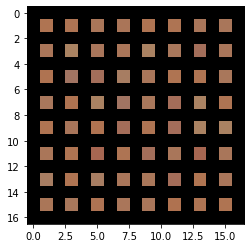

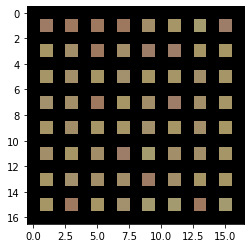

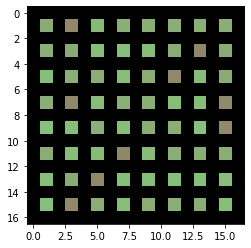

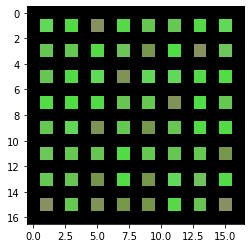

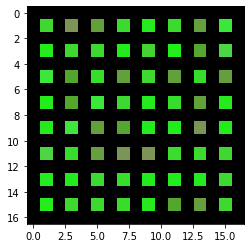

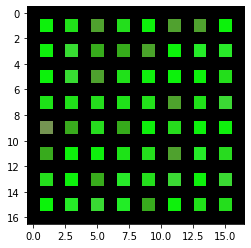

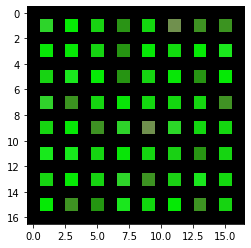

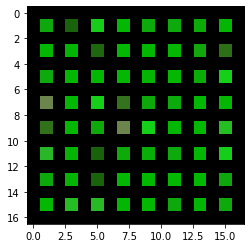

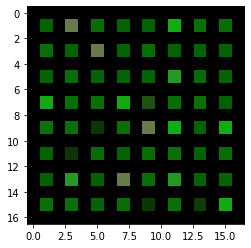

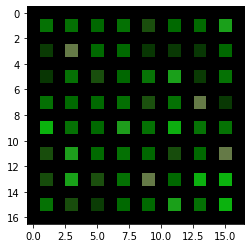

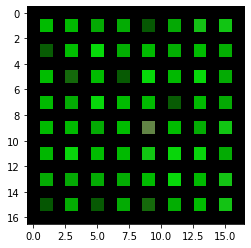

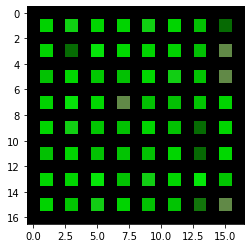

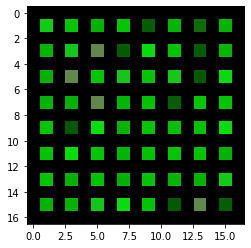

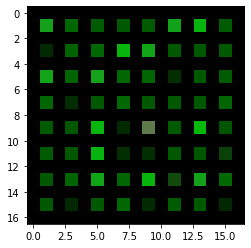

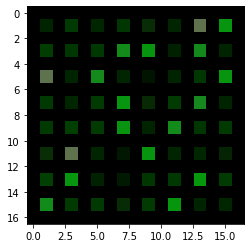

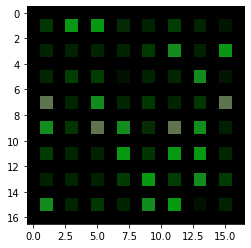

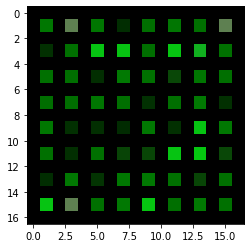

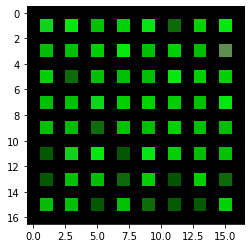

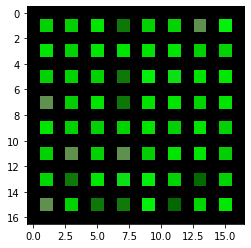

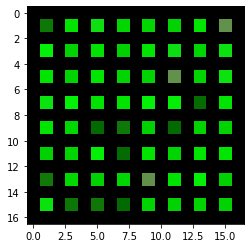

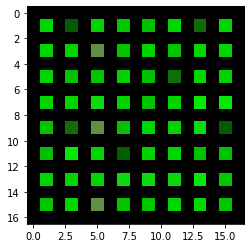

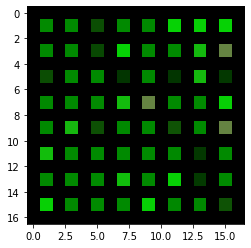

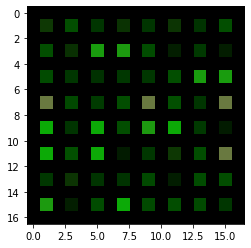

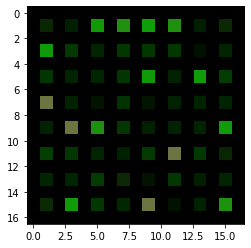

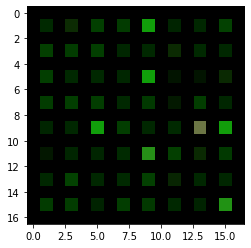

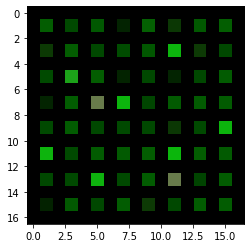

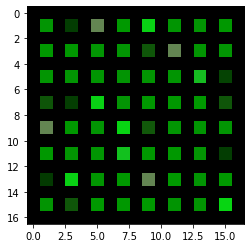

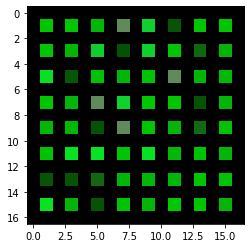

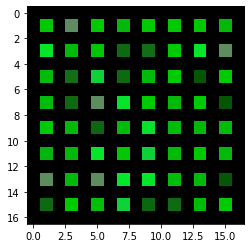

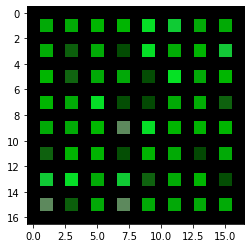

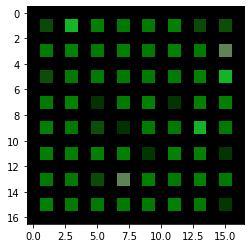

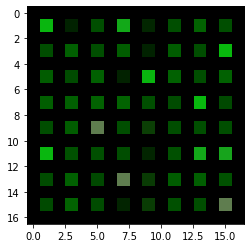

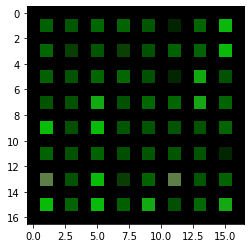

In [25]:
for img in samples_B:
    visualize_img_batch(img[:64])